### FastAI Models w ImageNet weight initialisation
<a id="fastai"></a>

In [2]:
# pytorch and fastai
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)

import os; os.chdir("/home/athon/thesis/notebooks")
from tools.config   import TCGA_MUT,GENE2VEC,FIGURES
from tools.somatic  import process_labels,filter_variants,filter_genes, \
                           visualise_distributions, dedup, reshape_pivot, \
                           convert_to_onehot, get_label_df
os.chdir("/home/athon/thesis/notebooks/1_distributed_genes")

---

In [3]:
def freememory():
    """
    Run garbage collection to free up memory.
    """
    import gc
    gc.collect()

def freegpu(data, model):
    del data
    del model
    freememory()
    torch.cuda.empty_cache()
    freememory()

In [4]:
def train_stage1(data_dir, arch=models.resnet34, cycles=10, bs=32):
    data = (ImageList.from_folder(data_dir + '/')
            .split_by_folder(train='train', valid='valid')
            .label_from_folder()
#             .transform(size=512)
            .databunch(bs=bs)
            .normalize(imagenet_stats)
           )    
    ## To create a ResNET 34 with pretrained weights
    learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
    learn.lr_find(stop_div=False, num_it=1000, end_lr=0.1)
    learn.recorder.plot(suggestion=True)
    min_grad_lr = learn.recorder.min_grad_lr
    print("Minimum gradient learning rate: {}".format(min_grad_lr))
#     learn.fit_one_cycle(cycles, min_grad_lr)
    learn.save('stage-1')
    
    preds,y = learn.get_preds()
    top1 = accuracy(preds,y)
    top5 = top_k_accuracy(preds,y,5)
    print('stage1 acc: {}, top5: {}'.format(top1,top5))
    
    # Free up gpu and memory
    freegpu(data, learn)
    return top1,top5

def train_data(dims, clustering, norms, colours, archs=[models.resnet34], cycles=1):
    data_dirs = []
    for dim in dims:
        for alg in clustering:
            for norm in norms:
                for colour in colours:
                    data_dir = "../data/genevec_images/1d_clustering/dim={}_alg={}_norm={}_col={}".format(dim, alg, norm, colour)
                    data_dirs.append(data_dir)
         
    results = {'model':[],'dataset':[],'top1':[],'top5':[]}
    # iterate architectures
    for name, arch in archs:     
        # iterate models
        for data_dir in data_dirs:
            dim_ = int(''.join(x for x in data_dir if x.isdigit()))
            batch_size = int(2**13 / dim_)
            print("dir: {} bs:{}".format(data_dir, batch_size))
            top1,top5 = train_stage1(data_dir, arch, cycles, bs=batch_size)
            
            results['model'].append(name)
            results['dataset'].append(data_dir.split)
            results['top1'].append(top1.item())
            results['top5'].append(top5.item())
    return pd.DataFrame(results)

#### Experiment 1: 5 Epoch Iterative Search
- Idea here is to find an semi-optimal configuration by comparing within configurations and ignoring intersections. If there are N hyperparams each with M configurations, the number of iterations only needs to be N\*M iterations, to find the optimal of M configs for each N. With the number of current data and model intersections this is only approx 10 iterations.

- A full grid search would search every combination of hypermaram configurations, and require M^N iterations, currently 3\*3\*2\*2\*2 = 72 iterations. On 72 CPUs (say an SKLearn job), this would be very feasible but since we're at present working on a single P100 I'm favouring the above search.

In [5]:
%%time

# Data intersections
dims = [32,128,512]
clustering = ['MiniBatchKMeans','GaussianMixture']
colours = ['viridis','seismic']
norms = ['non-zero','abs-value']

# Model intersections
archs = [('resnet18',models.resnet18), 
         ('resnet34',models.resnet34), 
         ('resnet101',models.resnet101)]

# Model comparison, fix data
dims_=dims[0:1]; clustering_=clustering[0:1]; colours_=colours[0:1]; norms_=norms[0:1]
results_df = train_data(dims_, clustering_, norms_, colours_, archs)

# Fix models, compare data
archs_ = archs[0:1]

# Dims
dims_ = dims
results_df = results_df.append(train_data(dims_, clustering_, norms_, colours_, archs_))
dims_ = dims[0:1]

# Clusters
clustering_ = clustering
results_df = results_df.append(train_data(dims_, clustering_, norms_, colours_, archs_))
clustering_ = clustering[0:1]

# Colours
colours_ = colours
results_df = results_df.append(train_data(dims_, clustering_, norms_, colours_, archs_))
colours_ = colours[0:1]

# Norms
norms_ = norms
results_df = results_df.append(train_data(dims_, clustering_, norms_, colours_, archs_))
norms_ = norms[0:1]

dir: ../data/genevec_images/1d_clustering/dim=32_alg=MiniBatchKMeans_norm=non-zero_col=viridis bs:62


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
results_df

#### Experiment 2: Big Big Grid Search
- All 72 iterations, no regrets. Let's go

In [ ]:
# Data intersections
dims = [32,128,512]
clustering = ['MiniBatchKMeans','GaussianMixture']
colours = ['viridis','seismic']
norms = ['non-zero','abs-value']

# Model intersections
archs = [('resnet18',models.resnet18), 
         ('resnet34',models.resnet34), 
         ('resnet101',models.resnet101)]

results_df = train_data(dims, clustering, norms, colours, archs, cycles=10)

In [4]:
results_df = pd.read_csv('exp2_grid_results.csv', index_col=0)
results_df.sort_values('top1', ascending=False)

,model,dataset,top1,top5
62,resnet101,../data/genevec_images/dim=128_alg=GaussianMixture_norm=abs-value_col=viridis,0.515723,0.791405
61,resnet101,../data/genevec_images/dim=128_alg=GaussianMixture_norm=non-zero_col=seismic,0.506289,0.815514
57,resnet101,../data/genevec_images/dim=128_alg=MiniBatchKMeans_norm=non-zero_col=seismic,0.497904,0.803983
58,resnet101,../data/genevec_images/dim=128_alg=MiniBatchKMeans_norm=abs-value_col=viridis,0.496855,0.797694
60,resnet101,../data/genevec_images/dim=128_alg=GaussianMixture_norm=non-zero_col=viridis,0.491614,0.800839
56,resnet101,../data/genevec_images/dim=128_alg=MiniBatchKMeans_norm=non-zero_col=viridis,0.480084,0.814465
63,resnet101,../data/genevec_images/dim=128_alg=GaussianMixture_norm=abs-value_col=seismic,0.480084,0.793501
37,resnet34,../data/genevec_images/dim=128_alg=GaussianMixture_norm=non-zero_col=seismic,0.477987,0.796646
65,resnet101,../data/genevec_images/dim=512_alg=MiniBatchKMeans_norm=non-zero_col=seismic,0.476939,0.808176
59,resnet101,../data/genevec_images/dim=128_alg=MiniBatchKMeans_norm=abs-value_col=seismic,0.471698,0.803983


#### Recreate best result

epoch,train_loss,valid_loss,accuracy,time
0,2.835737,2.597576,0.255765,00:57
1,2.468313,2.542025,0.286164,00:57
2,2.347508,2.318283,0.327044,00:57
3,2.196997,2.195990,0.374214,00:57
4,2.086767,2.135575,0.378407,00:57
5,1.976182,1.988420,0.414046,00:57
6,1.882756,1.979267,0.417191,00:57
7,1.737171,1.823790,0.465409,00:57
8,1.535745,1.772414,0.496855,00:57
9,1.376558,1.779021,0.488470,00:57


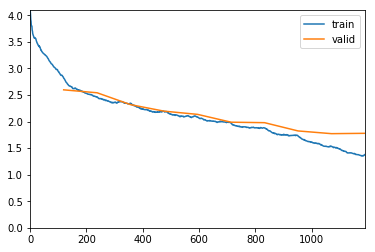

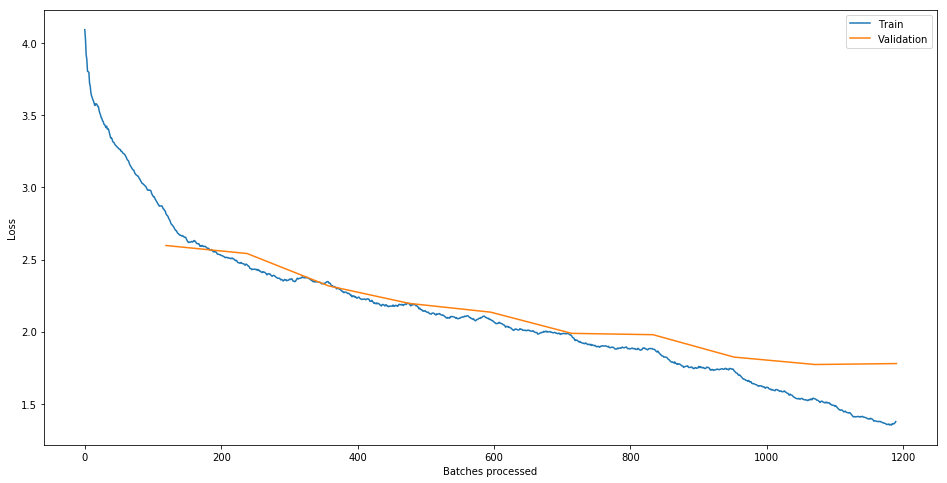

In [9]:
best_exp = '../../data/gene_images/1d_clustering/dim=128_alg=GaussianMixture_norm=abs-value_col=viridis'
data = (ImageList.from_folder(best_exp + '/')
        .split_by_folder(train='train', valid='valid')          
        .label_from_folder()
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )
arch = models.resnet101
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
learn.fit_one_cycle(10, 0.01)
fig = learn.recorder.plot_losses(return_fig=True)
fig.set_size_inches(16, 8)

epoch,train_loss,valid_loss,accuracy,time
0,1.375127,1.708936,0.500000,01:18
1,1.405905,1.808309,0.485325,01:18
2,1.342635,1.742606,0.495807,01:18
3,1.215519,1.740216,0.507338,01:18
4,1.113235,1.756405,0.503145,01:18


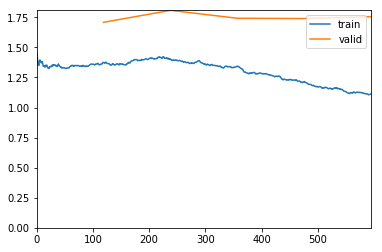

In [25]:
learn.unfreeze(); learn.fit_one_cycle(5, 0.0005)

In [23]:
preds,y = learn.get_preds()
top1 = accuracy(preds,y)
top5 = top_k_accuracy(preds,y,5)
print('stage1 acc: {}, top5: {}'.format(top1,top5))

stage1 acc: 0.5073375105857849, top5: 0.8238993883132935


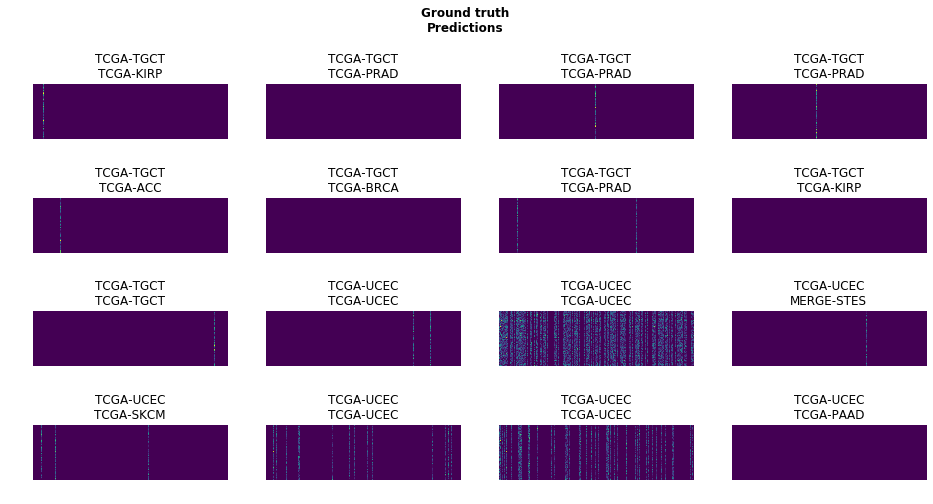

In [60]:
fig = learn.show_results(rows=4, ds_type=DatasetType.Valid, figsize=(16,8), cmap='Blues', return_fig=True)
# fig.savefig(FIGURES/'predictions.png')

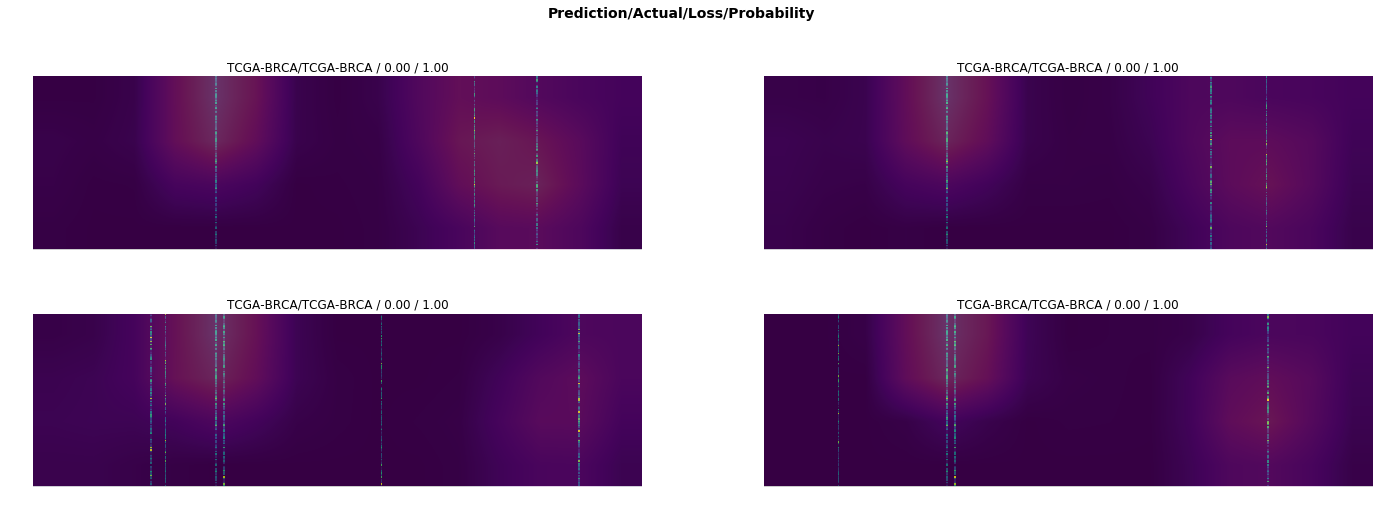

In [79]:
fig = interp.plot_top_losses(4, figsize=(24,8), return_fig=True, heatmap=True, largest=False, alpha=0.2)
fig.savefig(FIGURES/'top_performers.png', bbox_inches='tight', pad_inches=0.5)

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.confusion_matrix()
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100).astype('int')

In [21]:
# load in class order from other dataset
import pandas as pd
df_tcga = pd.read_csv(TCGA_MUT)

# process and filter
df_X    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1000)
                  .pipe(dedup)
                  .pipe(reshape_pivot))

df_tcga = pd.read_csv(TCGA_MUT)
df_y    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1000)
                  .pipe(get_label_df, df_X))
classes = df_y['project_short_name'].value_counts().index.values

order = [i for y in classes for i,x in enumerate(learn.data.y.classes) if x==y]
np.asarray(learn.data.y.classes)[order]

array(['TCGA-BRCA', 'MERGE-GBMLGG', 'MERGE-STES', 'TCGA-LUAD', 'MERGE-COADREAD', 'TCGA-UCEC', 'TCGA-HNSC', 'TCGA-LUSC',
       'TCGA-SKCM', 'TCGA-OV', 'TCGA-THCA', 'TCGA-PRAD', 'TCGA-BLCA', 'TCGA-LIHC', 'TCGA-KIRC', 'TCGA-CESC',
       'TCGA-KIRP', 'TCGA-SARC', 'TCGA-PAAD', 'TCGA-LAML', 'TCGA-PCPG', 'TCGA-TGCT', 'TCGA-ACC', 'TCGA-MESO',
       'TCGA-THYM', 'TCGA-UVM', 'TCGA-UCS', 'TCGA-KICH', 'TCGA-CHOL', 'TCGA-DLBC'], dtype='<U14')

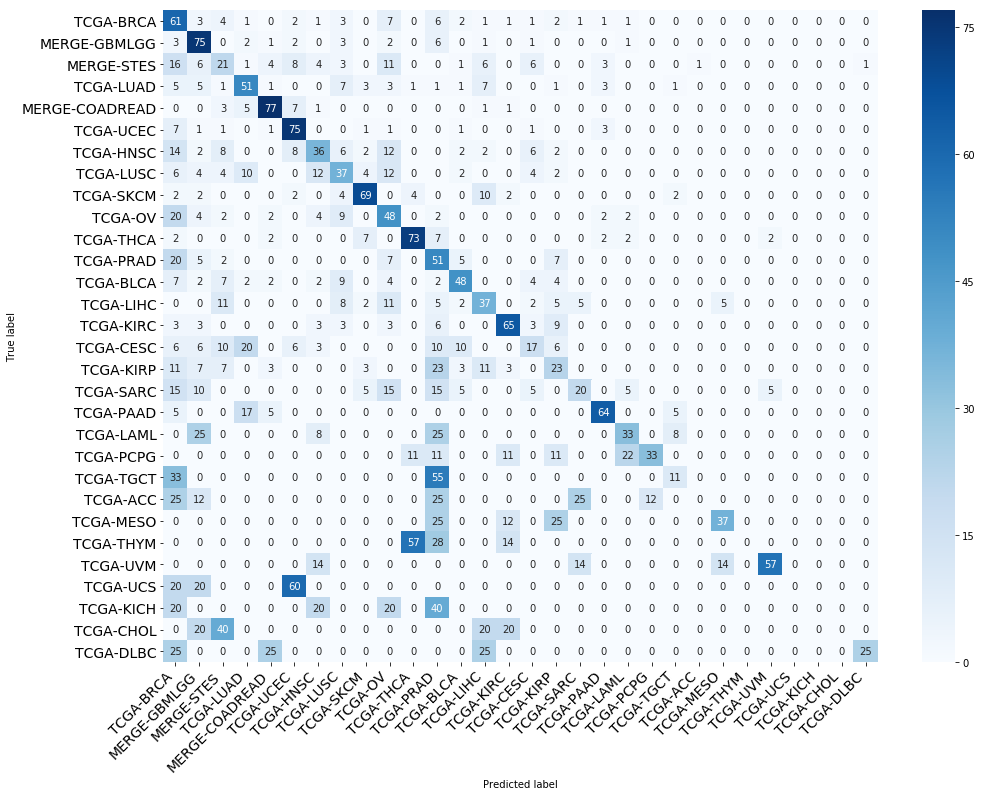

In [22]:
def print_confusion_matrix(confusion_matrix, class_names, fontsize=14, ax=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    import seaborn as sns
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylabel('True label')
    heatmap.set_xlabel('Predicted label')
    return heatmap

fig = plt.figure(figsize=(16,12))
print_confusion_matrix(cm_percent[order,:][:,order], np.asarray(learn.data.y.classes)[order])

fig.savefig(FIGURES/'cm_genevec.png', bbox_inches='tight', pad_inches=0.5)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, fontsize=14, ax=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=False, fmt="d", cmap="Blues", cbar=False, ax=ax)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylabel('True label')
    heatmap.set_xlabel('Predicted label')
    return heatmap

In [13]:
best_exp = '../../data/gene_images/2d_clustering/mutsigcv_thickened/dim=256_alg=MiniBatchKMeans_norm=non-zero_col=viridis'
data = (ImageList.from_folder(best_exp + '/')
        .split_by_folder(train='train', valid='valid')          
        .label_from_folder()
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )
arch = models.resnet34
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
learn.fit_one_cycle(10, 0.01)
preds,y = learn.get_preds()
top1 = accuracy(preds,y)
top5 = top_k_accuracy(preds,y,5)
print('stage1 acc: {}, top5: {}'.format(top1,top5))

# Free up gpu and memory
freegpu(data, learn)

stage1 acc: 0.43852460384368896, top5: 0.7612704634666443


Traceback (most recent call last):
  File "/home/athon/.conda/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/athon/.conda/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/athon/.conda/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/athon/.conda/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [7]:
best_exp = '../data/genevec_images/2d_clustering/dim=128_alg=MiniBatchKMeans_norm=non-zero_col=viridis'
data = (ImageList.from_folder(best_exp + '/')
        .split_by_folder(train='train', valid='valid')          
        .label_from_folder()
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )
arch = models.resnet34
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
learn.fit_one_cycle(10, 0.01)
preds,y = learn.get_preds()
top1 = accuracy(preds,y)
top5 = top_k_accuracy(preds,y,5)
print('stage1 acc: {}, top5: {}'.format(top1,top5))

# Free up gpu and memory
# freegpu(data, learn)

stage1 acc: 0.45597484707832336, top5: 0.7767295837402344


epoch,train_loss,valid_loss,accuracy,time
0,0.908737,1.893483,0.502096,00:24
1,1.236289,2.035450,0.444444,00:24
2,1.382387,2.158269,0.401468,00:24
3,1.367670,1.826067,0.474843,00:24
4,1.234211,1.989463,0.471698,00:24
5,1.082589,1.977224,0.483229,00:24
6,0.857984,2.041113,0.493711,00:24
7,0.666793,2.255382,0.480084,00:24
8,0.527601,2.333677,0.481132,00:24
9,0.443737,2.338925,0.484277,00:24


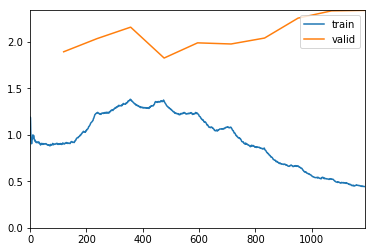

In [11]:
learn.fit_one_cycle(10, 0.005)

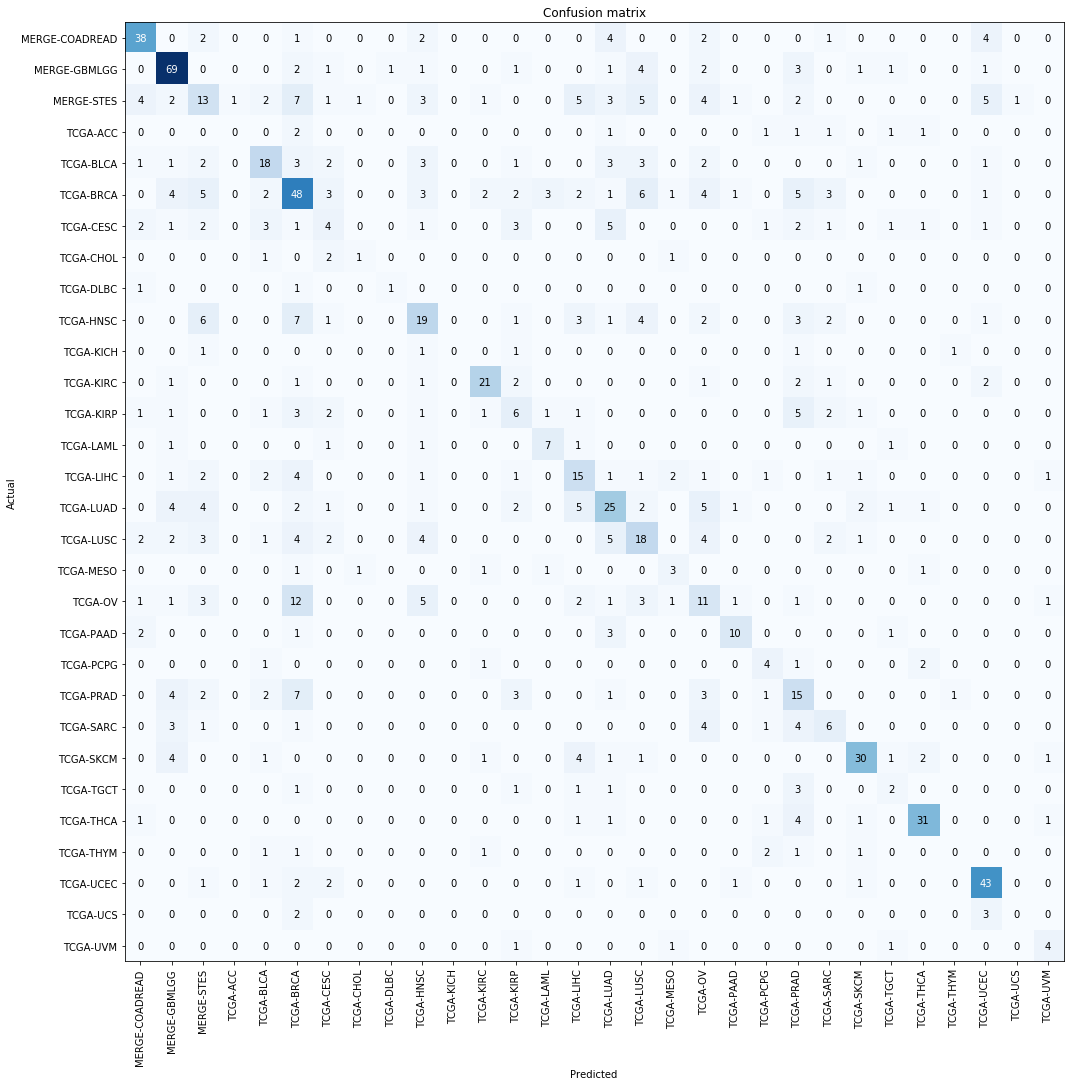

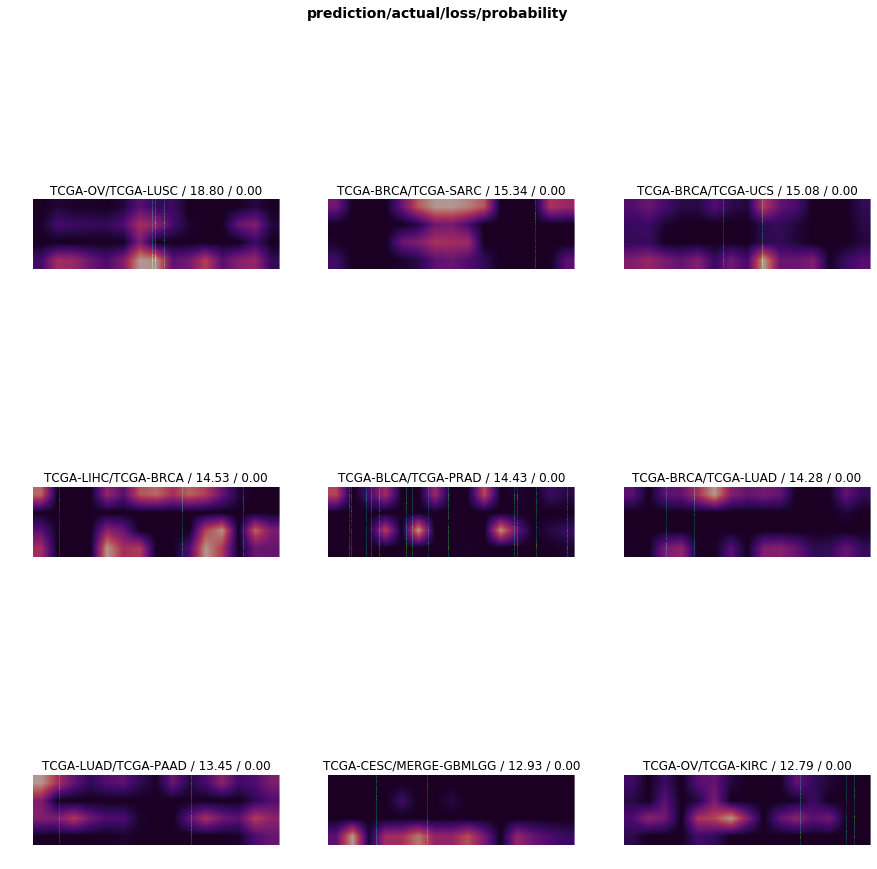

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(15,15))
interp.plot_top_losses(9, figsize=(15,15))

In [19]:
interp.confusion_matrix().sha

(30, 30)

#### Experiment 3: Honing in on best data results

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Minimum gradient learning rate: 0.0030199517204020166


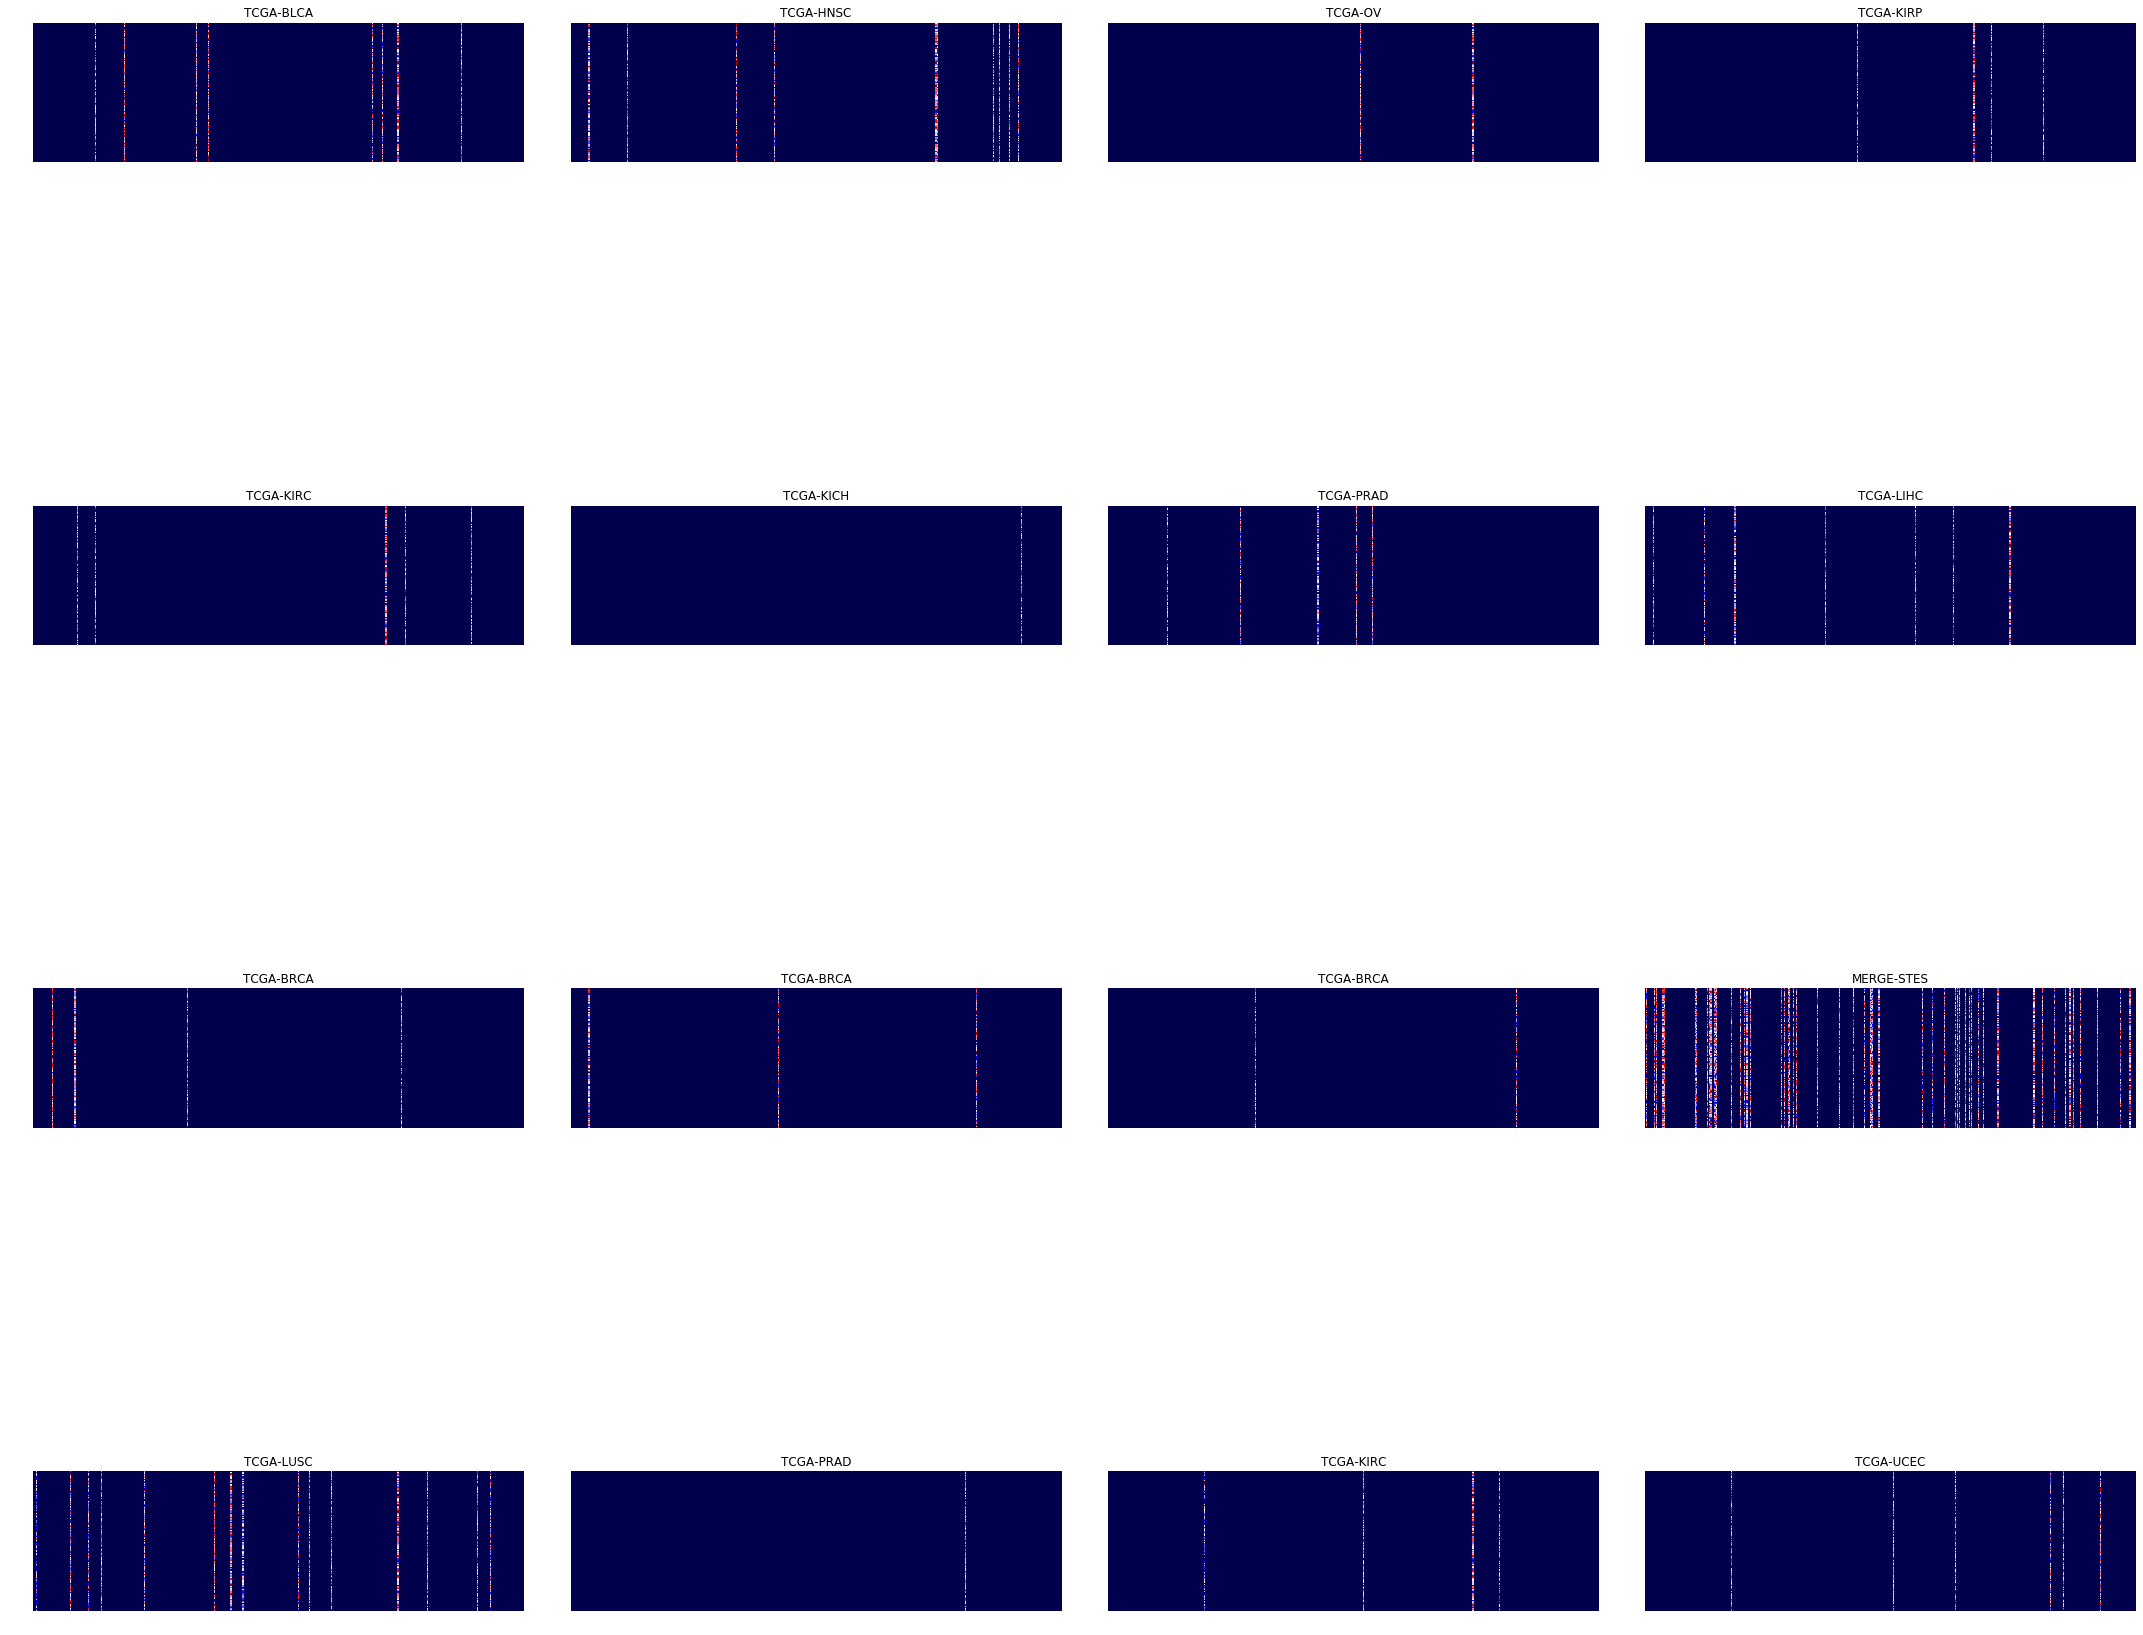

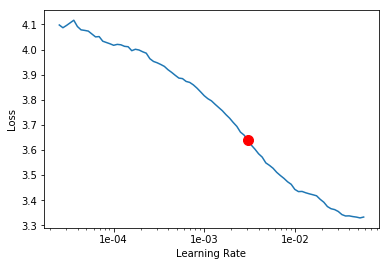

In [5]:
# take best experiment on resnet34 and see how well we can fine tune
best_exp = '../data/genevec_images/1d_clustering/dim=128_alg=GaussianMixture_norm=non-zero_col=seismic'
data = (ImageList.from_folder(best_exp + '/')
        .split_by_folder(train='train', valid='valid')          
        .label_from_folder()
        .databunch(bs=64)
        .normalize(imagenet_stats)
       )    
data.show_batch(rows=4, figsize=(30,30))
arch = models.resnet34

# Get first pass learning rate
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=ShowGraph)
learn.lr_find(stop_div=False, num_it=100, start_lr=1e-5, end_lr=0.1)
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
print("Minimum gradient learning rate: {}".format(min_grad_lr))

epoch,train_loss,valid_loss,accuracy,time
0,3.447261,2.859316,0.225367,00:19
1,2.867411,2.495355,0.291405,00:19
2,2.518023,2.270178,0.348008,00:18
3,2.325492,2.235531,0.352201,00:18
4,2.228820,2.197665,0.358491,00:18
5,2.144063,2.203429,0.368973,00:19
6,2.062658,2.104830,0.384696,00:18
7,1.987463,2.108520,0.412998,00:18
8,1.907715,2.177455,0.355346,00:18
9,1.820158,2.198727,0.368973,00:18


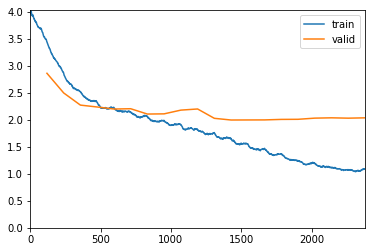

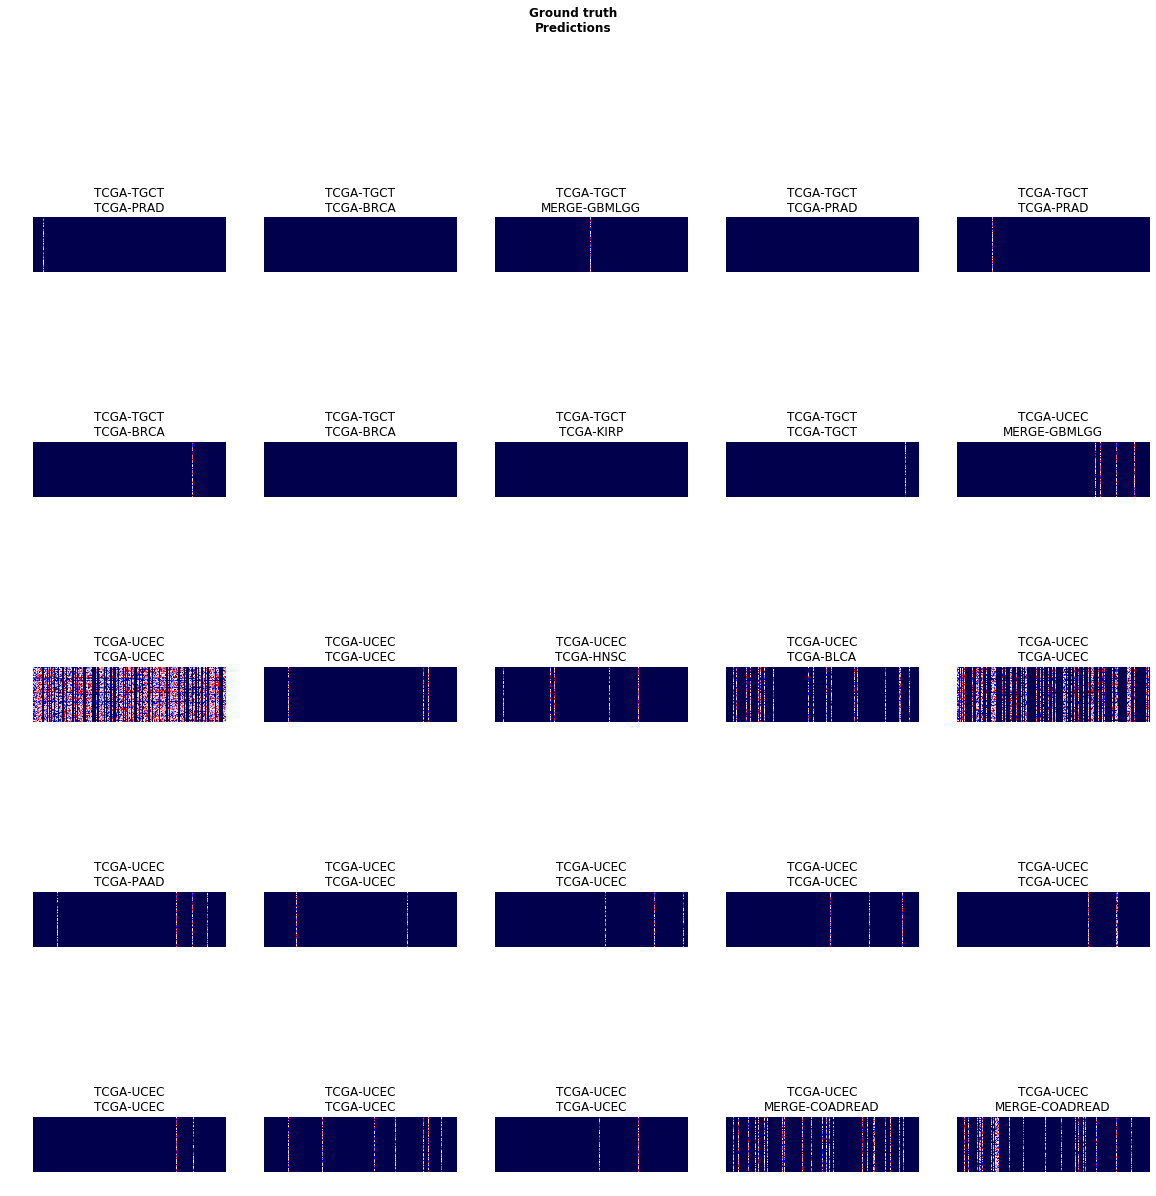

In [6]:
# Free up gpu and memory
freegpu(data, learn)

# Train 20 cycles and check validation vs training set performance.
learn.fit_one_cycle(20, min_grad_lr)
learn.show_results()
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Minimum gradient learning rate: 9.120108393559097e-07


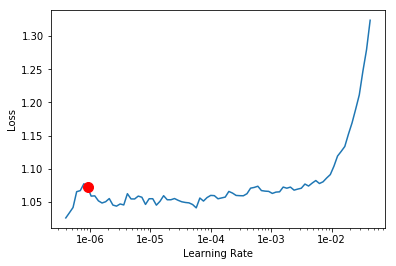

In [7]:
# Take another look at learning rate
learn.lr_find(stop_div=False, num_it=100, start_lr=1e-7, end_lr=0.1)
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
print("Minimum gradient learning rate: {}".format(min_grad_lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.074032,2.041184,0.437107,00:25
1,1.060532,2.036618,0.436059,00:25
2,1.054129,2.038213,0.438155,00:25
3,1.026802,2.038545,0.436059,00:25
4,1.045630,2.039207,0.435010,00:25


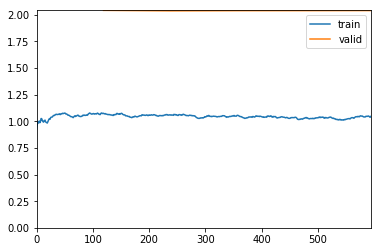

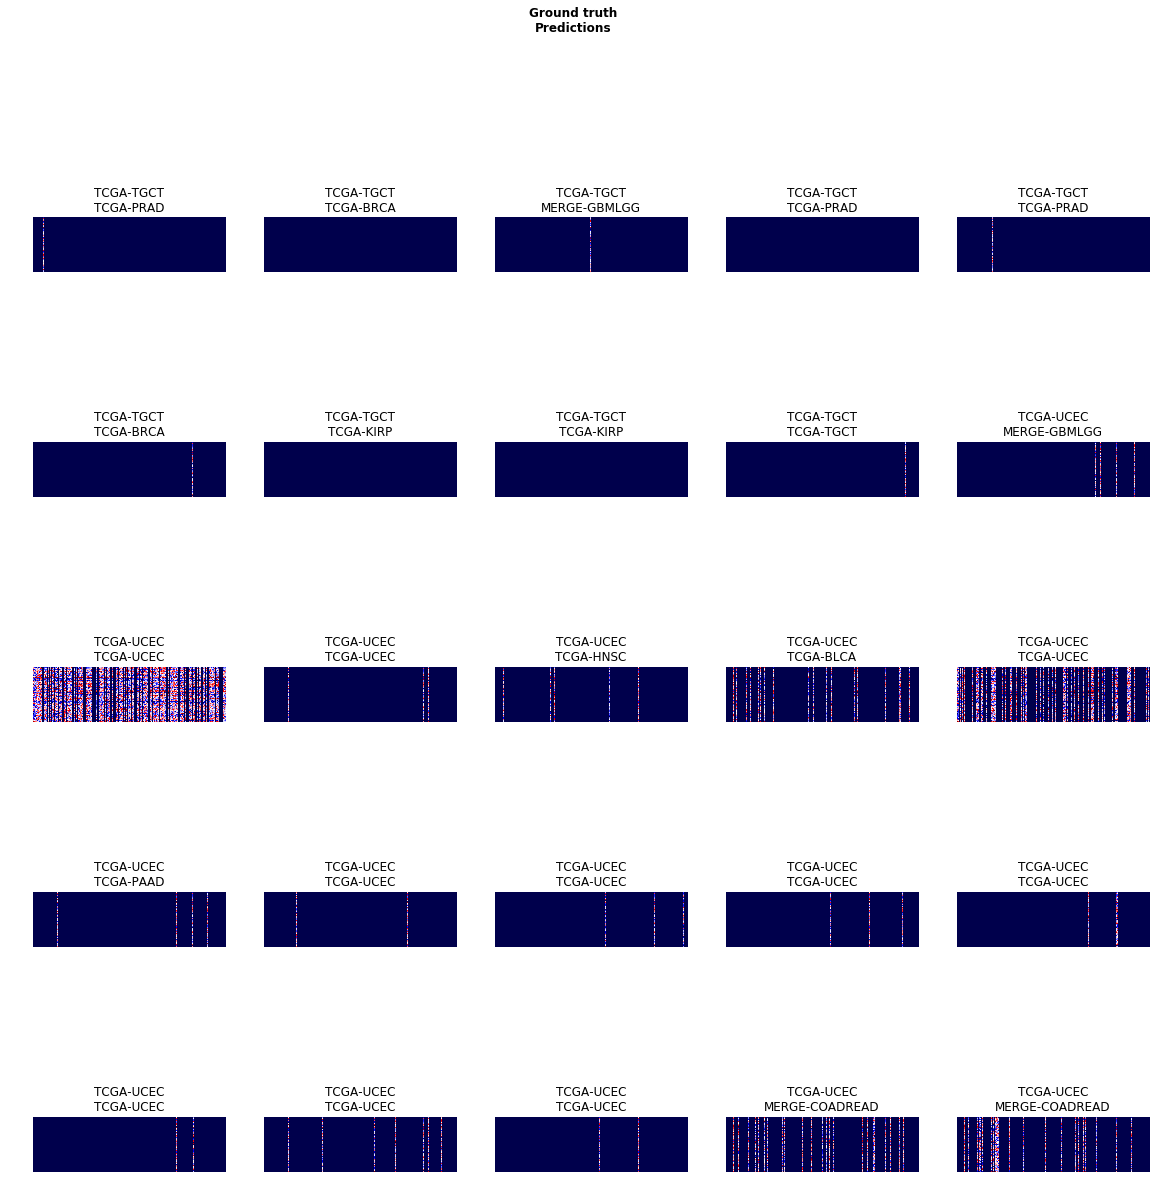

In [8]:
# Unlock layers and go again. 5 iterations this time.
learn.unfreeze()
learn.fit_one_cycle(5, min_grad_lr)
learn.show_results()
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.289827,2.316865,0.395178,00:24
1,1.567800,2.103851,0.422432,00:25
2,1.339116,2.029181,0.437107,00:25
3,1.006468,1.981976,0.454927,00:25
4,0.783183,1.991892,0.447589,00:25


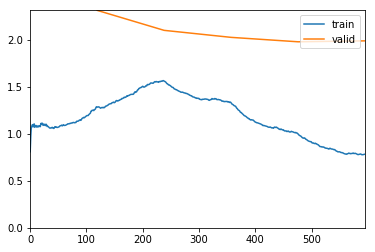

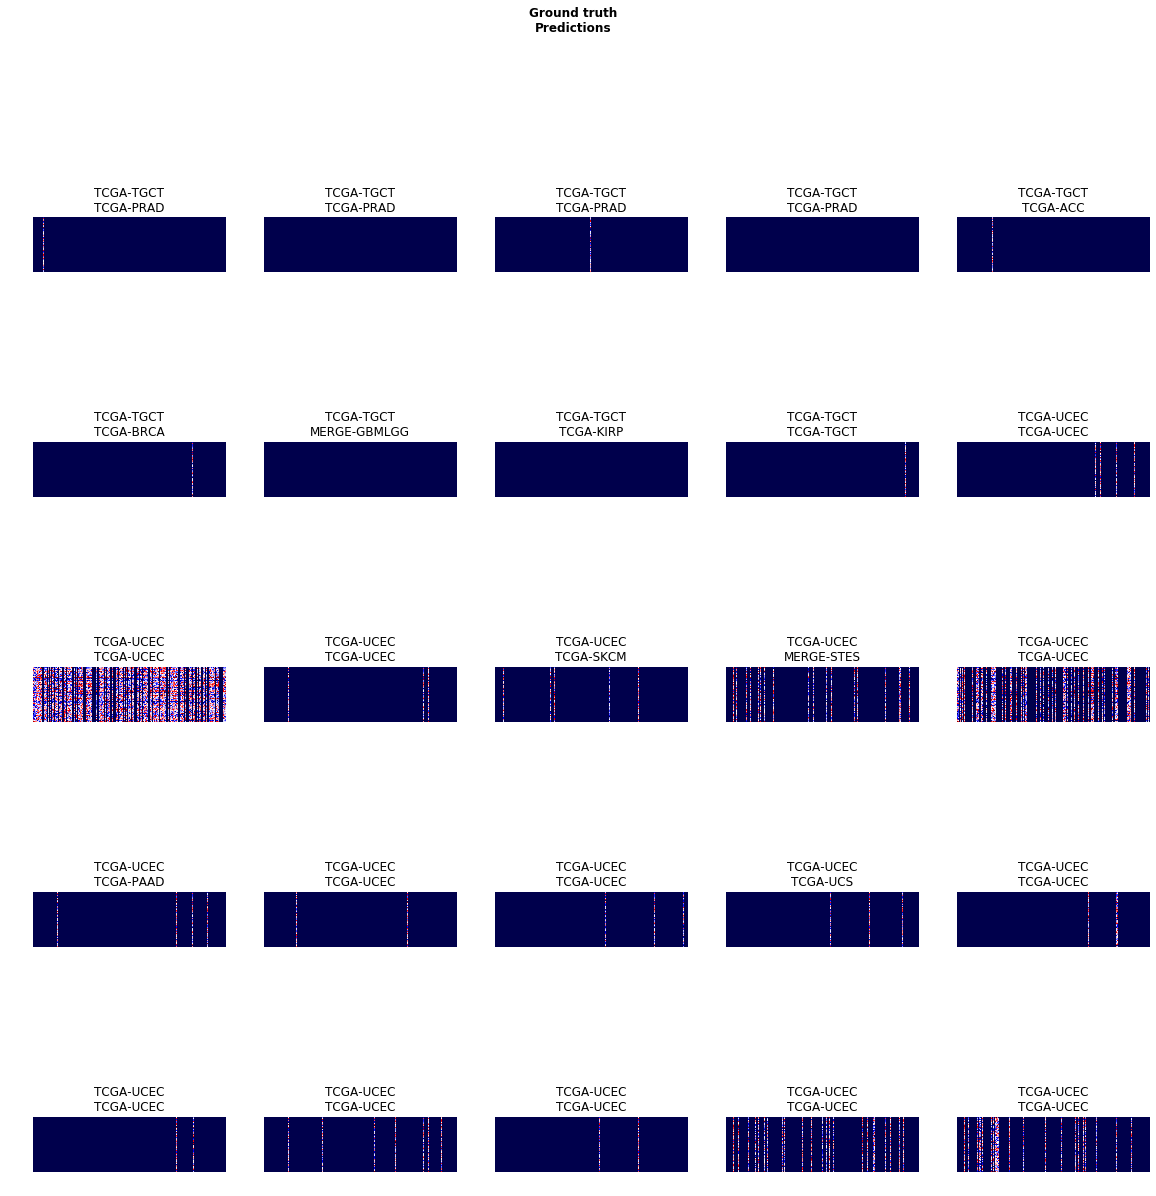

In [9]:
# Once more with a higher learning rate.
learn.fit_one_cycle(5, min_grad_lr*100)
learn.show_results()
learn.save('stage-1')